In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# Pandas set option (floating display)
pd.set_option('display.float_format', lambda x: '%.3f' %x)

# Set random seed, will be using sub samples
RANDOM_SEED = 100

# Visualizations options
plt.rcParams['font.size'] = 12
palette = sns.color_palette('Paired', 10)

In [3]:
# Only reading the first 5000000 rows

train_set = pd.read_csv('./archive/train.csv', nrows=5_000_000, 
                        parse_dates=['pickup_datetime']).drop('key', axis=1)

train_set.head(5)

fare_amount     pickup_datetime  pickup_longitude  pickup_latitude  \
0        4.500 2009-06-15 17:26:21           -73.844           40.721   
1       16.900 2010-01-05 16:52:16           -74.016           40.711   
2        5.700 2011-08-18 00:35:00           -73.983           40.761   
3        7.700 2012-04-21 04:30:42           -73.987           40.733   
4        5.300 2010-03-09 07:51:00           -73.968           40.768   

   dropoff_longitude  dropoff_latitude  passenger_count  
0            -73.842            40.712                1  
1            -73.979            40.782                1  
2            -73.991            40.751                2  
3            -73.992            40.758                1  
4            -73.957            40.784                1

In [4]:
# Any null values
train_set.isnull().values.any()

True

In [5]:
# Lets remove all na values
train_set = train_set.dropna()
train_set.head(5)

fare_amount     pickup_datetime  pickup_longitude  pickup_latitude  \
0        4.500 2009-06-15 17:26:21           -73.844           40.721   
1       16.900 2010-01-05 16:52:16           -74.016           40.711   
2        5.700 2011-08-18 00:35:00           -73.983           40.761   
3        7.700 2012-04-21 04:30:42           -73.987           40.733   
4        5.300 2010-03-09 07:51:00           -73.968           40.768   

   dropoff_longitude  dropoff_latitude  passenger_count  
0            -73.842            40.712                1  
1            -73.979            40.782                1  
2            -73.991            40.751                2  
3            -73.992            40.758                1  
4            -73.957            40.784                1

In [6]:
# Lets describe the data, perhaps find any outliers
train_set.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  4999964.000       4999964.000      4999964.000        4999964.000   
mean        11.341           -72.507           39.920            -72.507   
std          9.820            12.810            8.963             12.848   
min       -100.000         -3426.609        -3488.080          -3412.653   
25%          6.000           -73.992           40.735            -73.991   
50%          8.500           -73.982           40.753            -73.980   
75%         12.500           -73.967           40.767            -73.964   
max       1273.310          3439.426         3310.364           3457.622   

       dropoff_latitude  passenger_count  
count       4999964.000      4999964.000  
mean             39.917            1.685  
std               9.487            1.332  
min           -3488.080            0.000  
25%              40.734            1.000  
50%              40.753            1.000  
75%              40.768            2.000  
max            3345.917          208.000

Notes:
- There are outliers, we cannot have 208 passengers
- For longitude and latitude, there are also values that we should not expect... (in the max and min direction)
- For fare_amount, we cannot have negative values nor 1273 fare? Probably not..

## Data Exploration / Data Cleaning

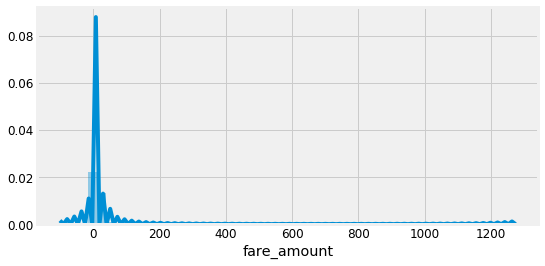

In [7]:
# Explore the target variable
plt.figure(figsize=(8, 4))
sns.distplot(train_set['fare_amount'])

Notes:
- We need to figure out why we have negative values...
- We need to figure out how we have some of the outliers...

In [8]:
len(train_set.loc[train_set['fare_amount']<0])

211

In [9]:
print(f"There are {len(train_set.loc[train_set['fare_amount']<0])} negative values")
print(f"There are {len(train_set.loc[train_set['fare_amount']==0])} zero values")
print(f"There are {len(train_set.loc[train_set['fare_amount']>200])} one-hundred fifty values")

There are 211 negative values
There are 132 zero values
There are 165 one-hundred fifty values


### Outliers

Notes:
- The minimum fare in NYC is 2.50 dollars (this is based on NYC info.)
- The maximum fare in NYC is 120 dollars (this could change)

In [10]:
train_set = train_set[train_set['fare_amount'].between(left=2.5, right=120)]

Text(0.5,1,'Distribution: fare-bin')

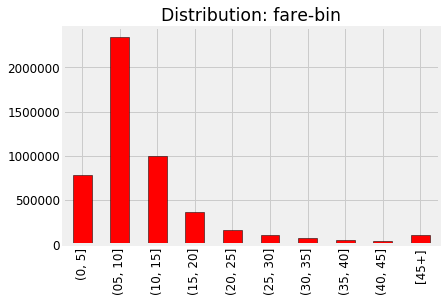

In [11]:
# Better visualization by binning out continous variable into a discrete variable
train_set['fare-bin'] = pd.cut(train_set['fare_amount'], bins=list(range(0, 50, 5))).astype(str)

# Upper-most bin
train_set.loc[train_set['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

# Formating the bin correctly
train_set.loc[train_set['fare-bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'

# Plot the values
train_set['fare-bin'].value_counts().sort_index().plot.bar(color='r', edgecolor='k');
plt.title('Distribution: fare-bin')

In [12]:
# Another way to view the data, and pick on outliers, is to view how the distribution occur
def ecdf(x):
    """Empirical cumulative distribution function of a variable"""
    
    # Sort in ascending order
    x = np.sort(x)
    n = len(x)
    
    # Go from 1/n to 1
    y = np.arange(1, n+1, 1) / n
    
    return x, y

Text(0.5,1,'ECDF of Fare Amount')

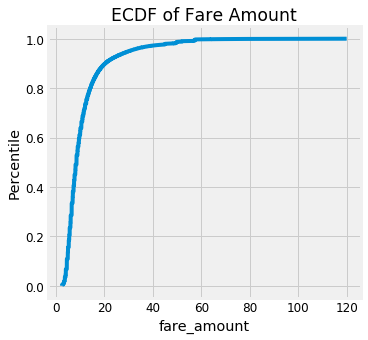

In [13]:
xs, ys = ecdf(train_set['fare_amount'])
plt.figure(figsize=(5,5))
plt.plot(xs, ys)
plt.ylabel('Percentile'); plt.xlabel('fare_amount'); plt.title('ECDF of Fare Amount')

Notes:
- Notice how a lot of the value occur before 20, thus indicating that the outlier after the 20 mark are outliers


**More Outliers**

`passenger_count`

(Text(0,0.5,'Count'),
 Text(0.5,0,'Passengers'),
 Text(0.5,1,'Distribution: Passenger'))

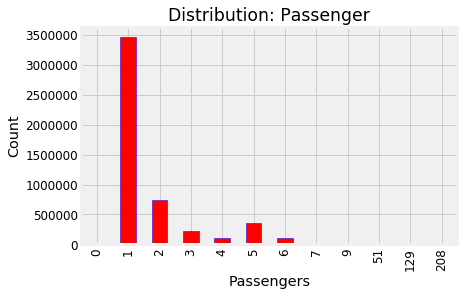

In [14]:
train_set['passenger_count'].value_counts().sort_index().plot.bar(color='r', edgecolor='b')
plt.ylabel('Count'), plt.xlabel('Passengers'), plt.title('Distribution: Passenger')

Notes:
- Anything above 6 does not look like it is possible answer


In [15]:
# removing values that are over 6 passengers
train_set = train_set.loc[train_set['passenger_count'] <= 6]

`latitude` and `longitude`

Notes:
- Given that we do not know much of the data we will encounter, we could use the percentiles to find values where it most probable to occur


In [16]:
long_lat_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

for col in long_lat_cols:
    print(f"{col.capitalize():17}: 2.5% = {round(np.percentile(train_set[col], 2.5), 2):5}")
    print(f"97.5% = {round(np.percentile(train_set[col], 97.5), 2):5}\n")

Pickup_longitude : 2.5% = -74.01
97.5% = -73.78

Pickup_latitude  : 2.5% = 40.64
97.5% =  40.8

Dropoff_longitude: 2.5% = -74.01
97.5% = -73.78

Dropoff_latitude : 2.5% = 40.64
97.5% = 40.81



Notes:
- Lets use the values to keep our latitude and longitude within the range

In [17]:
# Removing values 
train_set = train_set[train_set['pickup_longitude'].between(-75, -72)]
train_set = train_set[train_set['pickup_latitude'].between(40, 42)]
train_set = train_set[train_set['dropoff_longitude'].between(-75, -72)]
train_set = train_set[train_set['dropoff_latitude'].between(40, 42)]

train_set.shape

(4893381, 8)

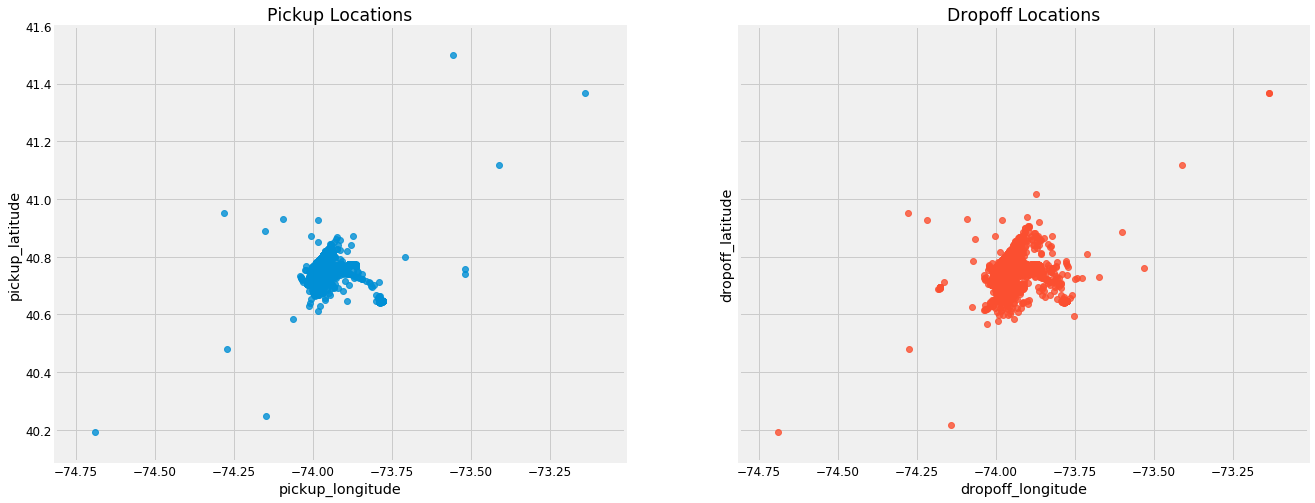

In [18]:
# Plotting the values of our location
# we are going to use a subsample

fig, axes = plt.subplots(1, 2, figsize = (20, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Plot Longitude (x) and Latitude (y)
sns.regplot('pickup_longitude', 'pickup_latitude', fit_reg = False, 
            data=train_set.sample(10000, random_state=RANDOM_SEED), ax = axes[0]);

sns.regplot('dropoff_longitude', 'dropoff_latitude', fit_reg = False, 
            data=train_set.sample(10000, random_state=RANDOM_SEED), ax = axes[1]);

axes[0].set_title('Pickup Locations')
axes[1].set_title('Dropoff Locations');

In [19]:
# load extra image to zoom in on NYC
BB_zoom = (-74.1, -73.7, 40.6, 40.85)
nyc_map_zoom = plt.imread('https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/images/nyc_-74.1_-73.7_40.6_40.85.PNG?raw=true')

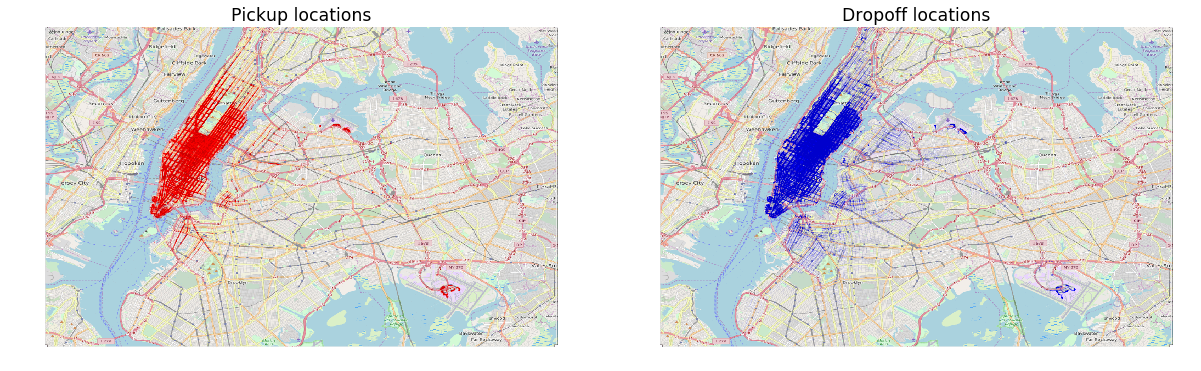

In [20]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2, color = False):
    fig, axs = plt.subplots(1, 2, figsize=(18, 22))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].axis('off')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='b', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].axis('off')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)
    
# plot training data on map zoomed in
plot_on_map(train_set.sample(1_000_000, random_state=RANDOM_SEED), 
            BB_zoom, nyc_map_zoom, s=0.05, alpha=0.05)

Notes
- Take note that more rides end up outside of Manhattan...

In [21]:
# Visualize fare-bin among the rides in NYC

# Mapping the fare-bin label to colors
color_map_fare_bin = {fare_bin: palette[i] for i, fare_bin in enumerate(train_set['fare-bin'].unique())}

# Using the map function to replace the values in the column in the dictionary
train_set['color'] = train_set['fare-bin'].map(color_map_fare_bin)

# A random sample of our data
plot_train_set = train_set.sample(1_000_000, random_state=RANDOM_SEED)

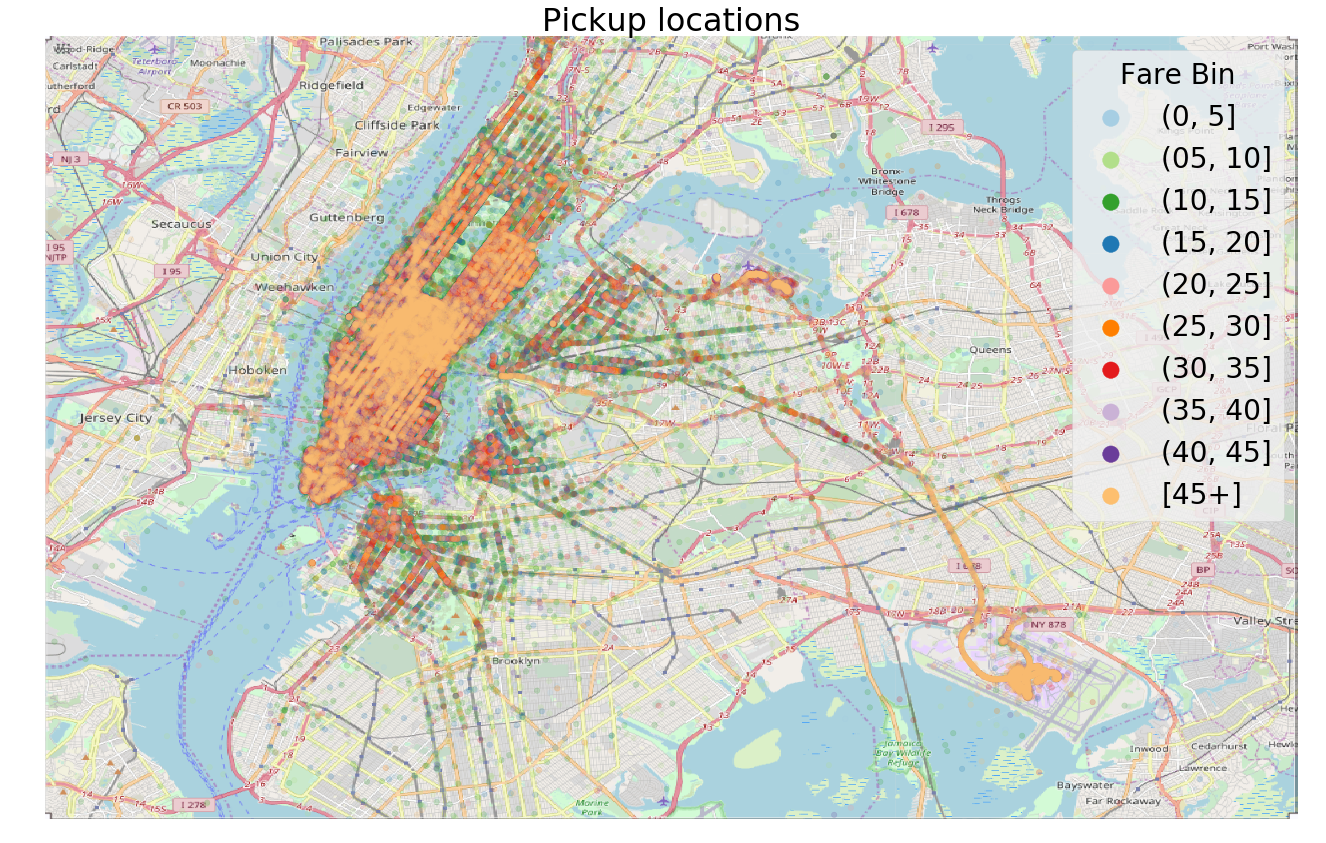

In [22]:
# Visualizing the fare_bin in NYC (pickups)

BB = BB_zoom

fig, axs = plt.subplots(1, 1, figsize=(20, 18))

# Plot the pickups
for b, df in plot_train_set.groupby('fare-bin'):
    # Set the zorder to 1 to plot on top of map
    axs.scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=0.2, c=df.color, s=30, label = f'{b}')
    axs.set_xlim((BB[0], BB[1]))
    axs.set_ylim((BB[2], BB[3]))
    axs.set_title('Pickup locations', size = 32)
    axs.axis('off')
    
# Legend
leg = axs.legend(fontsize = 28, markerscale = 3)

# Adjust alpha of legend markers
for lh in leg.legendHandles: 
    lh.set_alpha(1)

leg.set_title('Fare Bin', prop = {'size': 28})

# Show map in background (zorder = 0)
axs.imshow(nyc_map_zoom, zorder=0, extent=BB_zoom);

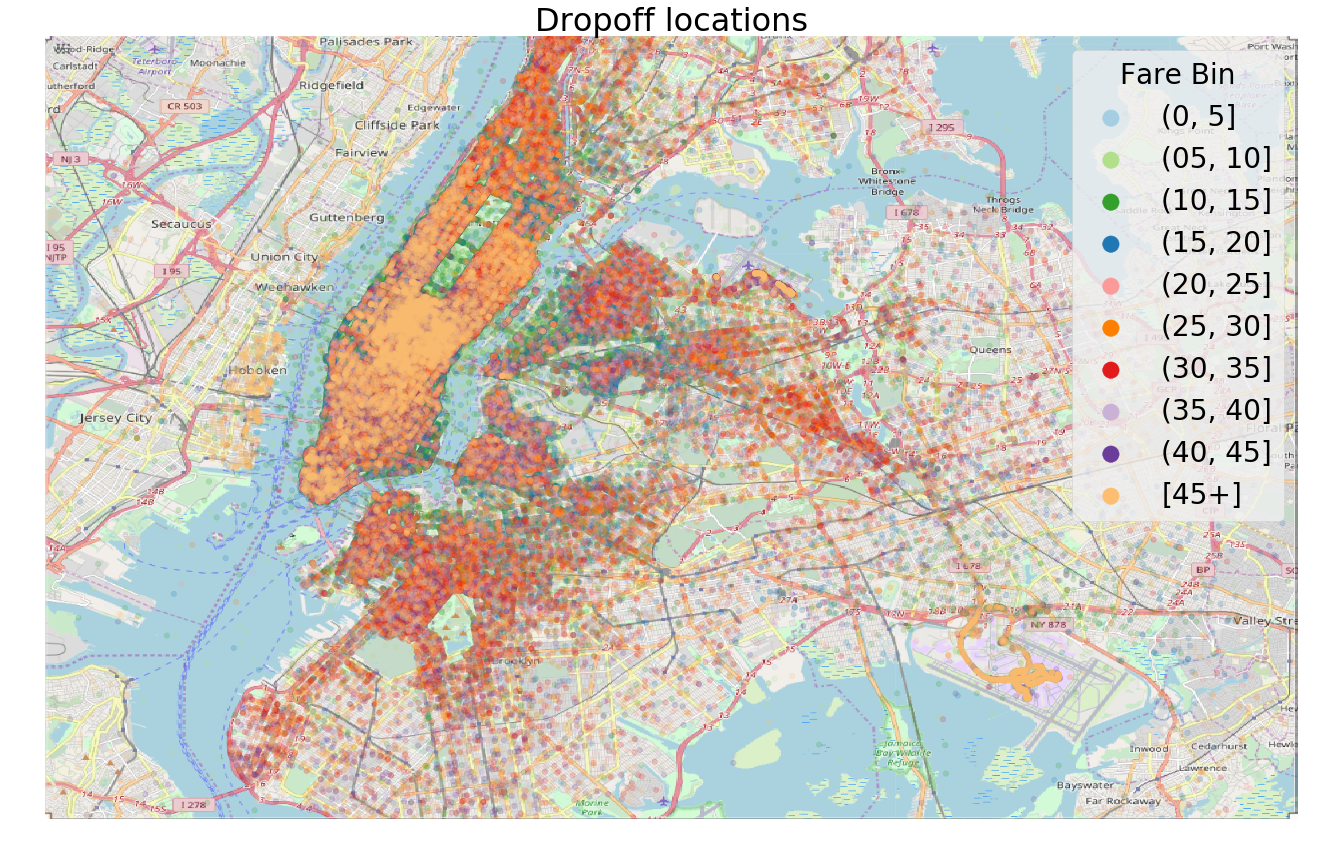

In [23]:
# Drop off location

fig, axs = plt.subplots(1, 1, figsize=(20, 18))

# Plot the pickups
for b, df in plot_train_set.groupby('fare-bin'):
    axs.scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, 
                alpha=0.2, c=df.color, s=30, label = f'{b}')
    axs.set_xlim((BB[0], BB[1]))
    axs.set_ylim((BB[2], BB[3]))
    axs.set_title('Dropoff locations', size = 32)
    axs.axis('off')
    
# Legend
leg = axs.legend(fontsize = 28, markerscale = 3)

# Adjust alpha of legend markers
for lh in leg.legendHandles: 
    lh.set_alpha(1)

leg.set_title('Fare Bin', prop = {'size': 28})

# Show map in background (zorder = 0)
axs.imshow(nyc_map_zoom, zorder=0, extent=BB_zoom);

## Feature Enginnering

`latitude` and `longitude` variables

Notes: 
- Being that its predicting the fare rate, analyzing the distance traveled should help us find appropriate variables
- Thus, understanding the `latitude` and `longitude` variables should help us
- We should also to look to where the distance is 0, surely, there should be some error if this were the case

In [24]:
# Abs. difference btw latitude and longitude
train_set['abs_diff_long'] = np.abs(train_set['pickup_longitude'] - train_set['dropoff_longitude'])
train_set['abs_diff_lat'] = np.abs(train_set['pickup_latitude'] - train_set['dropoff_latitude'])

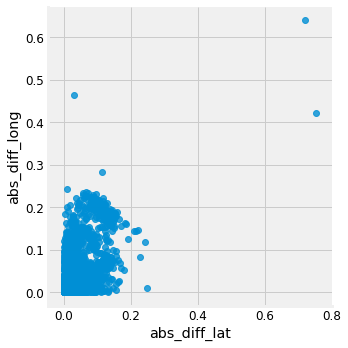

In [25]:
# Plotting the visualization
sns.lmplot('abs_diff_lat', 'abs_diff_long', fit_reg=False, 
           data=train_set.sample(10000, random_state=RANDOM_SEED))

In [26]:
no_diff = len(train_set[(train_set['abs_diff_lat'] == 0) & (train_set['abs_diff_long'] == 0)])
print(f"There are {no_diff} instances where the latitude and longitude have no difference")

There are 51965 instances where the latitude and longitude have no difference


Notes:
- The observation made above, 51965 instances of no differences, looks a stranger. 

/Users/alexguanga/anaconda/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5,1,'Distances Traveled Segemented by Fare-Bin')

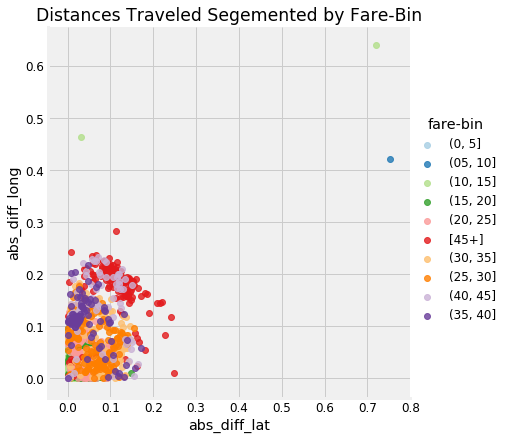

In [27]:
# Visualize the total distance by the fare-bin
sns.lmplot('abs_diff_lat', 'abs_diff_long', fit_reg=False, hue='fare-bin', palette=palette, size=6,
           data=train_set.sample(10000, random_state=RANDOM_SEED))
plt.title("Distances Traveled Segemented by Fare-Bin")

/Users/alexguanga/anaconda/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5,1,'Distances Traveled Segemented by Fare-Bin Btw. The Given Range')

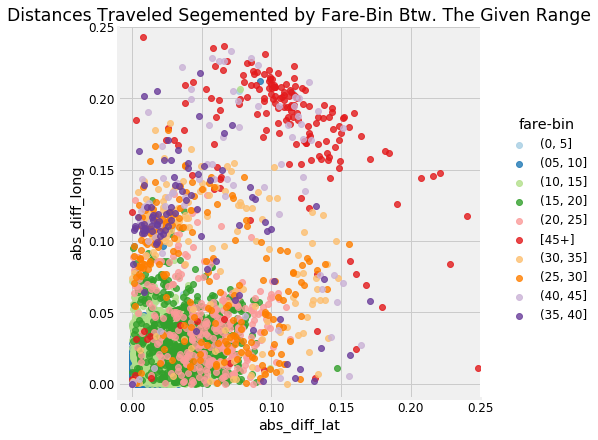

In [28]:
# Visualize the total distance by the fare-bin
sns.lmplot('abs_diff_lat', 'abs_diff_long', fit_reg=False, hue='fare-bin', palette=palette, size=6,
           data=train_set.sample(10000, random_state=RANDOM_SEED))
plt.xlim((-.01, .25)), plt.ylim((-0.01, .25))
plt.title("Distances Traveled Segemented by Fare-Bin Btw. The Given Range")

Notes: 
- We visualize that as move further along the x and y axis, top right corner, the fare-bin tends to become more expensive
- Like thought of before, calculating the Euclidean Distance should be helpful (even the Manhattan Distance)
    - Euclidean Distance: the square root of the sum of differences squared
    - Manhattan Distance: add up the two differences in latitude and longitude
    - Minkowski Distance: implememts the Euclidean and Manhattan Distance
        - $D(X,Y)=(∑_{i=1}^n|x_i−y_i|^p)^1/p$
        - if p = 1, then this is the Manhattan distance and if p = 2 this is the Euclidean distance. You may also see these referred to as the l1 or l2 norm where the number indicates p in the equation.

In [29]:
def minkowski_distance(x1, x2, y1, y2, p):
    """Returns the Manhattan or Euclidean Distance depending on the p parameters"""
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)

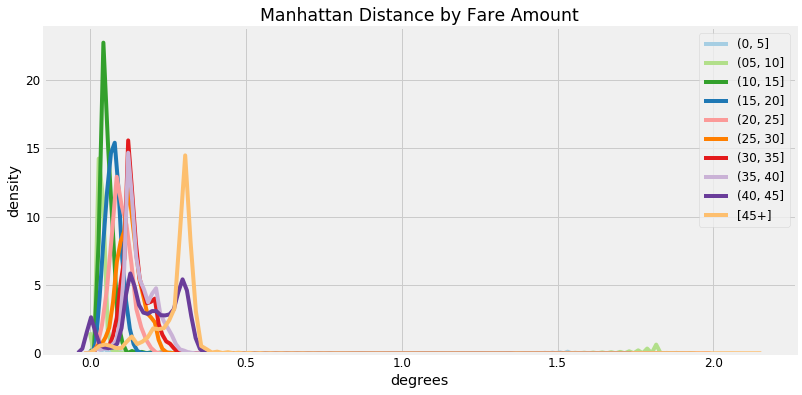

In [30]:
train_set['Manhattan_dist'] = minkowski_distance(train_set['pickup_longitude'], train_set['dropoff_longitude'],
                                                 train_set['pickup_latitude'], train_set['dropoff_latitude'], 1)

# Calculate distribution by each fare bin
plt.figure(figsize = (12, 6))
for f, grouped in train_set.groupby('fare-bin'):
    sns.kdeplot(grouped['Manhattan_dist'], label=f'{f}', color=list(grouped['color'])[0]);

plt.xlabel('degrees'); plt.ylabel('density')
plt.title('Manhattan Distance by Fare Amount');

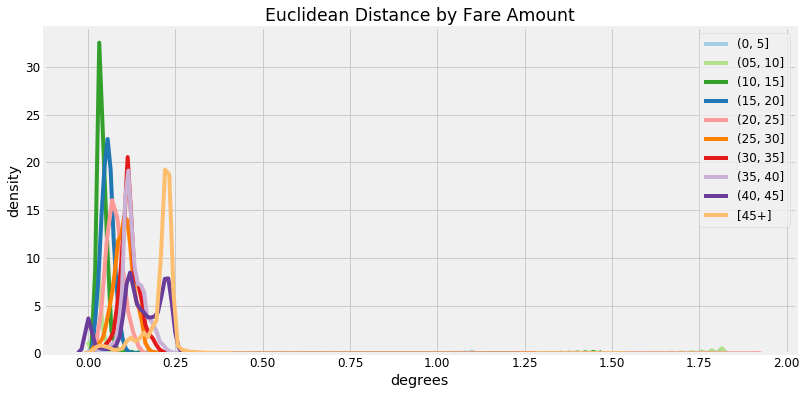

In [31]:
train_set['Euclidean_dist'] = minkowski_distance(train_set['pickup_longitude'], train_set['dropoff_longitude'],
                                                 train_set['pickup_latitude'], train_set['dropoff_latitude'], 2)

# Calculate distribution by each fare bin
plt.figure(figsize = (12, 6))
for f, grouped in train_set.groupby('fare-bin'):
    sns.kdeplot(grouped['Euclidean_dist'], label=f'{f}', color=list(grouped['color'])[0]);

plt.xlabel('degrees'); plt.ylabel('density')
plt.title('Euclidean Distance by Fare Amount');

Notes:
- Both graphs display difference distributions, we might be able to use this information

In [32]:
# Analyzing the Euclidean and Manhattan values
print(train_set.groupby('fare-bin')['Manhattan_dist'].agg(['mean', 'count']))
print(train_set.groupby('fare-bin')['Euclidean_dist'].agg(['mean', 'count']))

          mean    count
fare-bin               
(0, 5]   0.012   760323
(05, 10] 0.025  2298539
(10, 15] 0.048   977231
(15, 20] 0.072   358784
(20, 25] 0.097   155199
(25, 30] 0.125    96922
(30, 35] 0.142    71285
(35, 40] 0.154    41367
(40, 45] 0.193    34094
[45+]    0.252    99637
          mean    count
fare-bin               
(0, 5]   0.009   760323
(05, 10] 0.019  2298539
(10, 15] 0.037   977231
(15, 20] 0.055   358784
(20, 25] 0.075   155199
(25, 30] 0.101    96922
(30, 35] 0.117    71285
(35, 40] 0.128    41367
(40, 45] 0.153    34094
[45+]    0.191    99637


Text(0.5,1,'Average Euclidean Distnce by fare-bin')

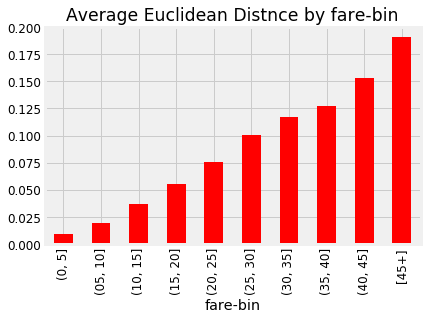

In [33]:
# Visualizing the mean by fare-bin
train_set.groupby('fare-bin')['Euclidean_dist'].mean().sort_index().plot.bar(color='r')
plt.title('Average Euclidean Distnce by fare-bin')

`passenger_count`

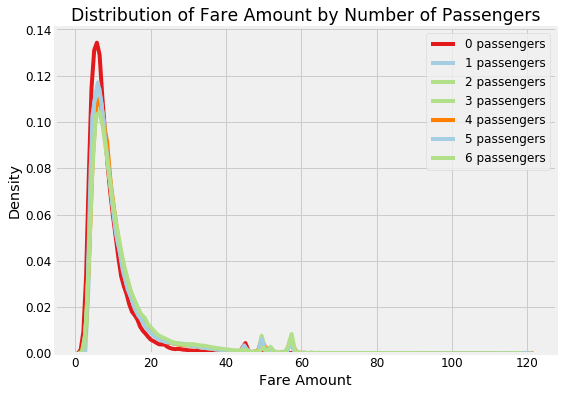

In [34]:
plt.figure(figsize = (8, 6))

for p, grouped in train_set.groupby('passenger_count'):
    sns.kdeplot(grouped['fare_amount'], label=f'{p} passengers', color=list(grouped['color'])[0]);
    
plt.xlabel('Fare Amount'); plt.ylabel('Density')
plt.title('Distribution of Fare Amount by Number of Passengers');

In [35]:
train_set.groupby('passenger_count')['fare_amount'].agg(['mean', 'count'])

mean    count
passenger_count                
0                8.938    17215
1               11.159  3384303
2               11.777   723528
3               11.528   214806
4               11.736   103869
5               11.194   346122
6               12.139   103538

Text(0.5,1,'Average fare by passenger count')

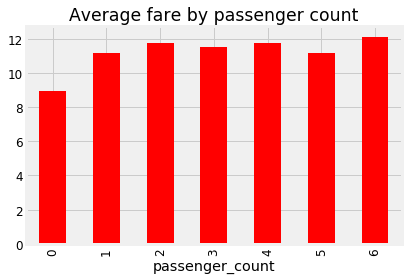

In [36]:
train_set.groupby('passenger_count')['fare_amount'].mean().sort_index().plot.bar(color='r')
plt.title('Average fare by passenger count')

Notes:
- We do not see much difference in their distribution

## Test Set

Notes:
- We have to make sure that we add the same columns in the training set to the testing set
- We cannot remove values in the testing set because of outliers
- We should not use the testing set other than training our model

In [37]:
test_set = pd.read_csv('./archive/test.csv', parse_dates=['pickup_datetime'])

# Creating the features we created for the training set
test_set['abs_diff_long'] = np.abs(test_set['pickup_longitude'] - test_set['dropoff_longitude'])
test_set['abs_diff_lat'] = np.abs(test_set['pickup_latitude'] - test_set['dropoff_latitude'])

# Save the key for submission
test_id = list(test_set.pop('key'))

# Describe our test set
test_set.describe()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count          9914.000         9914.000           9914.000          9914.000   
mean            -73.975           40.751            -73.974            40.752   
std               0.043            0.034              0.039             0.035   
min             -74.252           40.573            -74.263            40.569   
25%             -73.993           40.736            -73.991            40.735   
50%             -73.982           40.753            -73.980            40.754   
75%             -73.968           40.767            -73.964            40.769   
max             -72.987           41.710            -72.991            41.697   

       passenger_count  abs_diff_long  abs_diff_lat  
count         9914.000       9914.000      9914.000  
mean             1.671          0.023         0.022  
std              1.279          0.037         0.026  
min              1.000          0.000         0.000  
25%              1.000          0.006         0.007  
50%              1.000          0.013         0.015  
75%              2.000          0.025         0.028  
max              6.000          0.849         0.633

Notes:
- Notice how we had irregular value sin our training set, we do not see the same in the testing set

In [38]:
# More values to add to our testing set
test_set['Manhattan_dist'] = minkowski_distance(test_set['pickup_longitude'], test_set['dropoff_longitude'],
                                                 test_set['pickup_latitude'], test_set['dropoff_latitude'], 1)
test_set['Euclidean_dist'] = minkowski_distance(test_set['pickup_longitude'], test_set['dropoff_longitude'],
                                                 test_set['pickup_latitude'], test_set['dropoff_latitude'], 2)



`Haverstine_dist`

Notes:
- We'll be using the haverstine distance to have a more accurate distance btw the longitude and latitude...
- $2rarcsin √{sin^2((φ_2−φ_1)/2) + cos(φ_1)cos(φ_2)sin^2((λ_2−λ_1)/2)}$

In [39]:
# Calculating the formula of above

R = 6378

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points on the earth (specified in decimal degrees)

    All args must be of equal length.    
    
    source: https://stackoverflow.com/a/29546836

    """
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    km = R * c
    
    return km

In [40]:
train_set.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'fare-bin',
       'color', 'abs_diff_long', 'abs_diff_lat', 'Manhattan_dist',
       'Euclidean_dist'],
      dtype='object')

In [41]:
# Updating our datasets

train_set['Haverstine_dist'] = haversine_np(train_set['pickup_longitude'], train_set['pickup_latitude'],
                                            train_set['dropoff_longitude'], train_set['dropoff_latitude'])

test_set['Haverstine_dist'] = haversine_np(test_set['pickup_longitude'], test_set['pickup_latitude'],
                                           test_set['dropoff_longitude'], test_set['dropoff_latitude'])

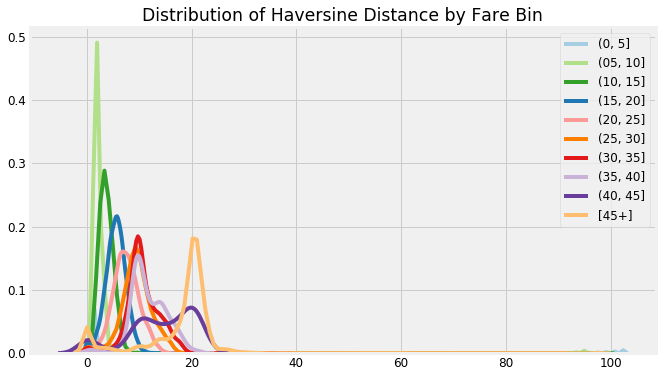

In [42]:
# Visualizing the Haverstine_dist

subset = train_set.sample(100_000, random_state=RANDOM_SEED)
plt.figure(figsize=(10,6))

for group_title, group_values in subset.groupby('fare-bin'):
    sns.kdeplot(group_values['Haverstine_dist'], label = f'{group_title}', color = list(group_values['color'])[0]);

plt.title('Distribution of Haversine Distance by Fare Bin');
    

Notes:
- Similar insight as to the Euclidean or Manhattan distance. The longer the distance, indicated by the y-axis, the more expensive the fare-bin is, indicated by the key legend

In [43]:
# More in-depth insight to the distribution
train_set.groupby('fare-bin')['Haverstine_dist'].agg(['mean', 'count'])

mean    count
fare-bin                
(0, 5]    0.911   760323
(05, 10]  1.931  2298539
(10, 15]  3.695   977231
(15, 20]  5.565   358784
(20, 25]  7.510   155199
(25, 30]  9.502    96922
(30, 35] 10.719    71285
(35, 40] 11.615    41367
(40, 45] 13.933    34094
[45+]    17.522    99637

Text(0,0.5,'Haverstine Mean Distance')

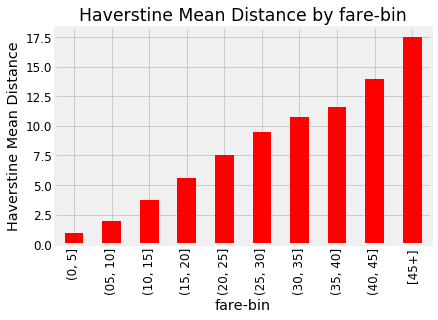

In [44]:
# Visalizing the information of above
train_set.groupby('fare-bin')['Haverstine_dist'].mean().sort_index().plot.bar(color='r')
plt.title('Haverstine Mean Distance by fare-bin')
plt.ylabel('Haverstine Mean Distance')

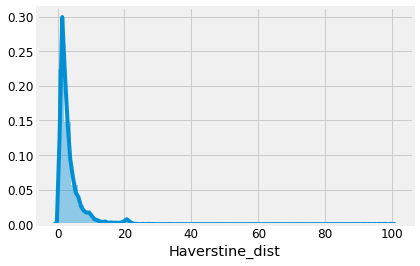

In [45]:
# Since we cannot segement the testing by fare-bin, we could see its distribution
# to verify if its aligns with the distribution from our training set

sns.distplot(test_set['Haverstine_dist'])

Text(0.5,1,'Correlation Bar')

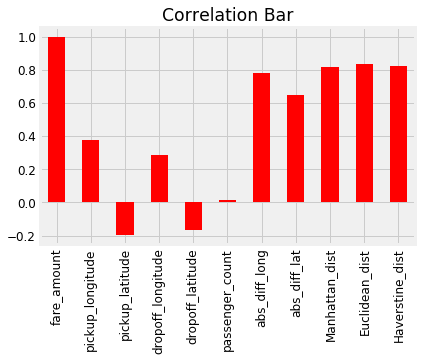

In [46]:
# For the last step, lets understand the correlation of our training set
corrs = train_set.corr()
corrs['fare_amount'].plot.bar(color='r')
plt.title('Correlation Bar')

Notes:
- Given that much of the variables have a strong corrrelation with the target variable, we could use an advanced regression technique (e.g. Ridge Regression) for our models

In [48]:
# View all dataframes in notebook
%who DataFrame

corrs	 df	 group_values	 grouped	 plot_train_set	 subset	 test_set	 train_set	 


In [49]:
import pickles

# Saving the sets for future use
train_set.to_pickle("./pickles/train_set.pkl")
test_set.to_pickle("./pickles/test_set.pkl")